# Trénovanie modelu iba na základe DST indexu 6h dopredu 6 dozadu
Súbor: 3_model_lstm_iba_dst.ipynb

Program: Hospodárska informatika

Vypracovala: Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 21.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 25.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard

### Kontrola kapacity servera

In [2]:
!nvidia-smi

Sun Oct 23 11:57:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:01:00.0 Off |                    0 |
| 23%   41C    P0    69W / 235W |      0MiB / 11441MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

2022-10-23 11:57:17.183255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 11:57:17.355149: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [4]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [5]:
df.columns

Index(['Unnamed: 0', 'time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS',
       'ABS_B', 'F', 'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE',
       'BY_GSM', 'BZ_GSM', 'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By',
       'SIGMA$Bz', 'T', 'N', 'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure',
       'SIGMA$T', 'SIGMA$N', 'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V',
       'SIGMA$ratio', 'E', 'Beta', 'Mach_num', 'Mgs_mach_num', 'PR$FLX_1',
       'PR$FLX_2', 'PR$FLX_4', 'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX',
       'R', 'F10_INDEX', 'KP', 'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX',
       'PC_N_INDEX', 'Solar_Lyman_alpha', 'Proton_QI', 'DST+1', 'DST+2',
       'DST+3', 'DST+4', 'DST+6', 'DST+8', 'DST+12', 'DST+24'],
      dtype='object')

In [6]:
features = ['time1',
           'DST',
            'DST+6']

In [7]:
df = df[features]

In [8]:
df['time1']=pd.to_datetime(df['time1'])

In [9]:
df.dropna(inplace=True)
print(len(df))

520437


In [10]:
predicted_label = 'DST+6'

In [11]:
df.describe()

,DST,DST+6
count,520437.000000,520437.000000
mean,-14.125120,-14.125220
std,22.034938,22.034877
min,-589.000000,-589.000000
25%,-22.000000,-22.000000
50%,-10.000000,-10.000000
75%,-1.000000,-1.000000
max,81.000000,81.000000


In [12]:
df[predicted_label].describe()

count    520437.000000
mean        -14.125220
std          22.034877
min        -589.000000
25%         -22.000000
50%         -10.000000
75%          -1.000000
max          81.000000
Name: DST+6, dtype: float64

In [13]:
df.head()

,time1,DST,DST+6
6,1963-01-01 07:00:00,-9.0,-5.0
7,1963-01-01 08:00:00,-6.0,-5.0
8,1963-01-01 09:00:00,-2.0,-3.0
9,1963-01-01 10:00:00,-2.0,-3.0
10,1963-01-01 11:00:00,-5.0,-6.0


<AxesSubplot: >

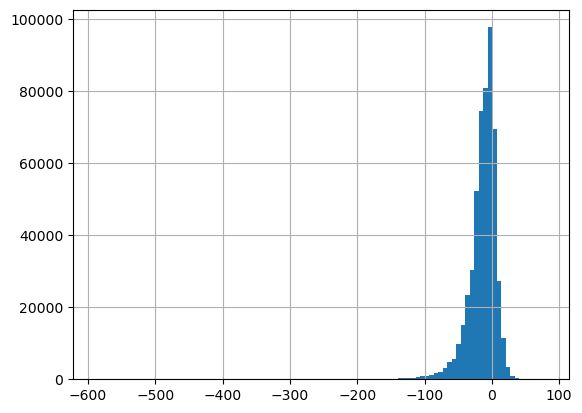

In [14]:
df[predicted_label].hist(bins=100)

In [15]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

count    5.204370e+05
mean     3.113677e-01
std      2.271201e-01
min      5.948783e-24
25%      1.176383e-01
50%      2.837766e-01
75%      4.727973e-01
max      9.993474e-01
Name: contcontinuous_transforminuous_transform, dtype: float64

In [16]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST+6'
#y_col='contcontinuous_transforminuous_transform'

In [17]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [18]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [19]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()

y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [20]:
print(y_test[0:40])

[ -7.  -9.  -9. -12. -13. -13. -12. -12. -17. -17. -15. -11.  -8. -12.
 -16. -14. -14. -14. -15. -17. -13. -15. -24. -21. -17. -15. -17. -25.
 -27. -26. -27. -27. -25. -26. -20. -16. -14. -14. -16. -16.]


In [21]:
len(y_test)

104087

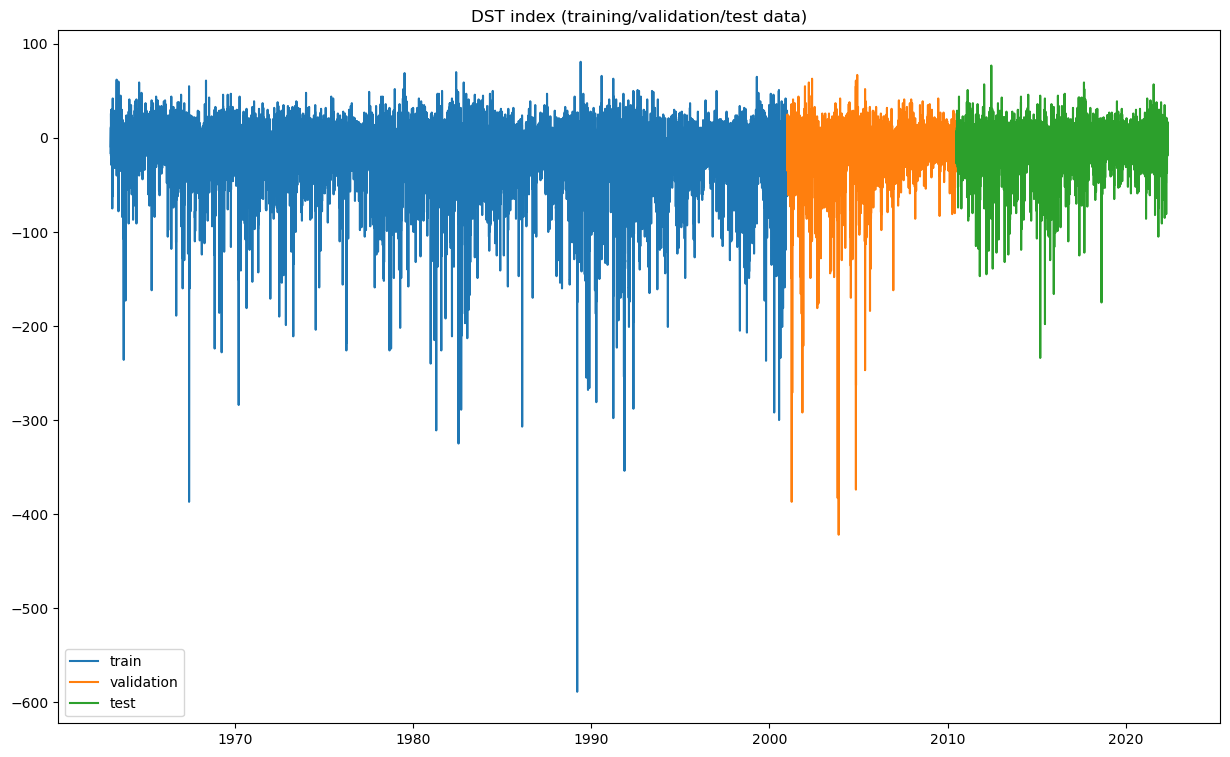

In [22]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [23]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [24]:
#for i in range(len(test_generator)):
#	x, y = test_generator[i]
#	print('tt %s => %s' % (x, y))

In [25]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1302
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [26]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2022-10-23 11:57:35.264347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 11:57:35.823817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10779 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:01:00.0, compute capability: 3.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                             

In [27]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 256)           133120    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 7   

In [28]:
# callbacks
saved_model = "6_dozadu_6_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [29]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2022-10-23 11:57:45.055213: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1301/1302 [============================>.] - ETA: 0s - loss: 47.9601 - mae: 2.3221
Epoch 1: val_mae improved from inf to 3.34644, saving model to 6_dozadu_6_dopredu.hdf5
1302/1302 [==============================] - 81s 56ms/step - loss: 47.9369 - mae: 2.3230 - val_loss: 47.9242 - val_mae: 3.3464
Epoch 2/20
1302/1302 [==============================] - ETA: 0s - loss: 14.6950 - mae: 1.4002
Epoch 2: val_mae improved from 3.34644 to 1.52824, saving model to 6_dozadu_6_dopredu.hdf5
1302/1302 [==============================] - 71s 55ms/step - loss: 14.6950 - mae: 1.4002 - val_loss: 16.7208 - val_mae: 1.5282
Epoch 3/20
1302/1302 [==============================] - ETA: 0s - loss: 12.6385 - mae: 1.3155
Epoch 3: val_mae improved from 1.52824 to 1.48304, saving model to 6_dozadu_6_dopredu.hdf5
1302/1302 [==============================] - 72s 55ms/step - loss: 12.6385 - mae: 1.3155 - val_loss: 16.9690 - val_mae: 1.4830
Epoch 4/20
1302/1302 [==============================] - ETA: 0s - loss: 8.2357 

In [30]:
# load best model
model = keras.models.load_model('6_dozadu_6_dopredu.hdf5')

In [31]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 5s 10ms/step


In [32]:
y_pred

array([[-11.275275 ],
       [-11.467026 ],
       [-16.277245 ],
       ...,
       [ 10.006577 ],
       [  7.1629877],
       [  5.2819786]], dtype=float32)

In [33]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[83361     4]
 [ 2467 18249]]


In [34]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     83365
           1       1.00      0.88      0.94     20716

    accuracy                           0.98    104081
   macro avg       0.99      0.94      0.96    104081
weighted avg       0.98      0.98      0.98    104081



In [35]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

/tmp/ipykernel_40271/1533669817.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})


In [36]:
df

,time,y_true,y_predict
416362,2010-06-29 12:00:00,-12.0,-11.275275
416363,2010-06-29 13:00:00,-12.0,-11.467026
416364,2010-06-29 14:00:00,-17.0,-16.277245
416365,2010-06-29 15:00:00,-17.0,-16.122555
416366,2010-06-29 16:00:00,-15.0,-13.975517
...,...,...,...
520438,2022-05-13 12:00:00,11.0,10.030155
520439,2022-05-13 13:00:00,9.0,8.219292
520440,2022-05-13 14:00:00,11.0,10.006577
520441,2022-05-13 15:00:00,8.0,7.162988


In [37]:
df.describe()

,y_true,y_predict
count,104081.000000,104081.000000
mean,-9.641741,-9.088909
std,16.039950,14.593570
min,-234.000000,-174.605972
25%,-17.000000,-15.882802
50%,-7.000000,-6.761423
75%,0.000000,0.116460
max,77.000000,58.828739


<AxesSubplot: >

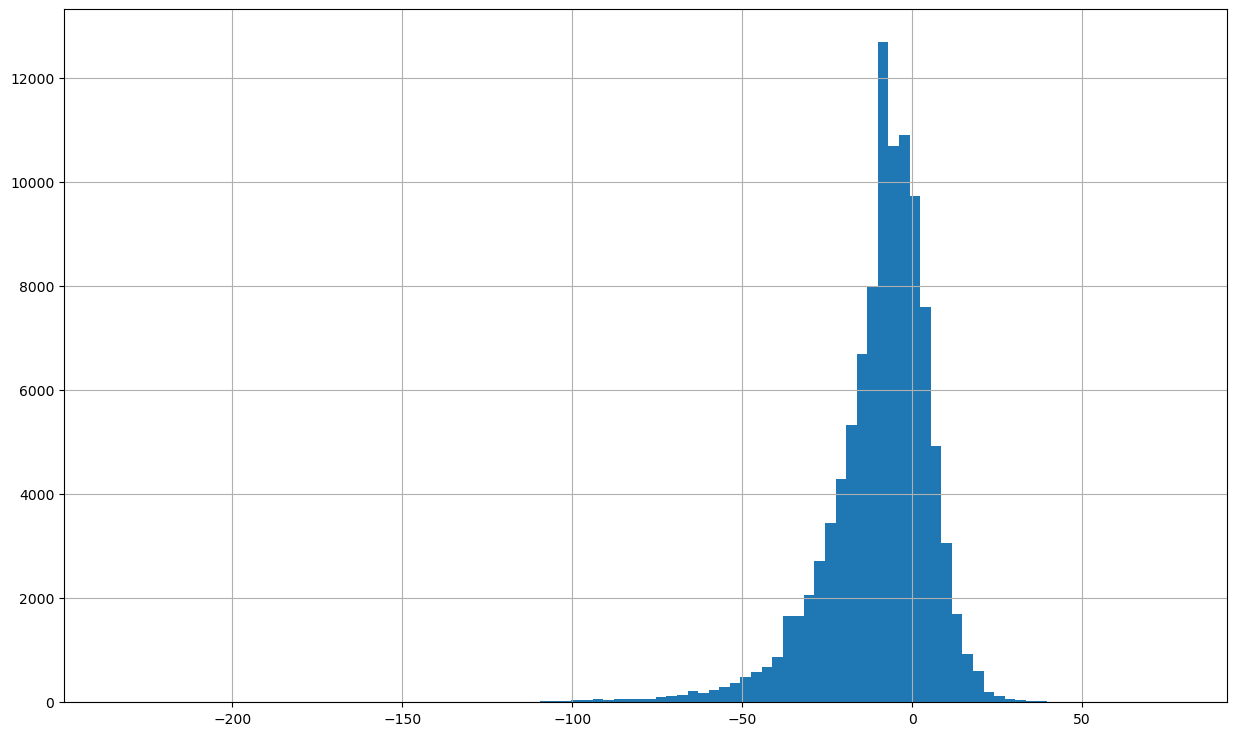

In [38]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

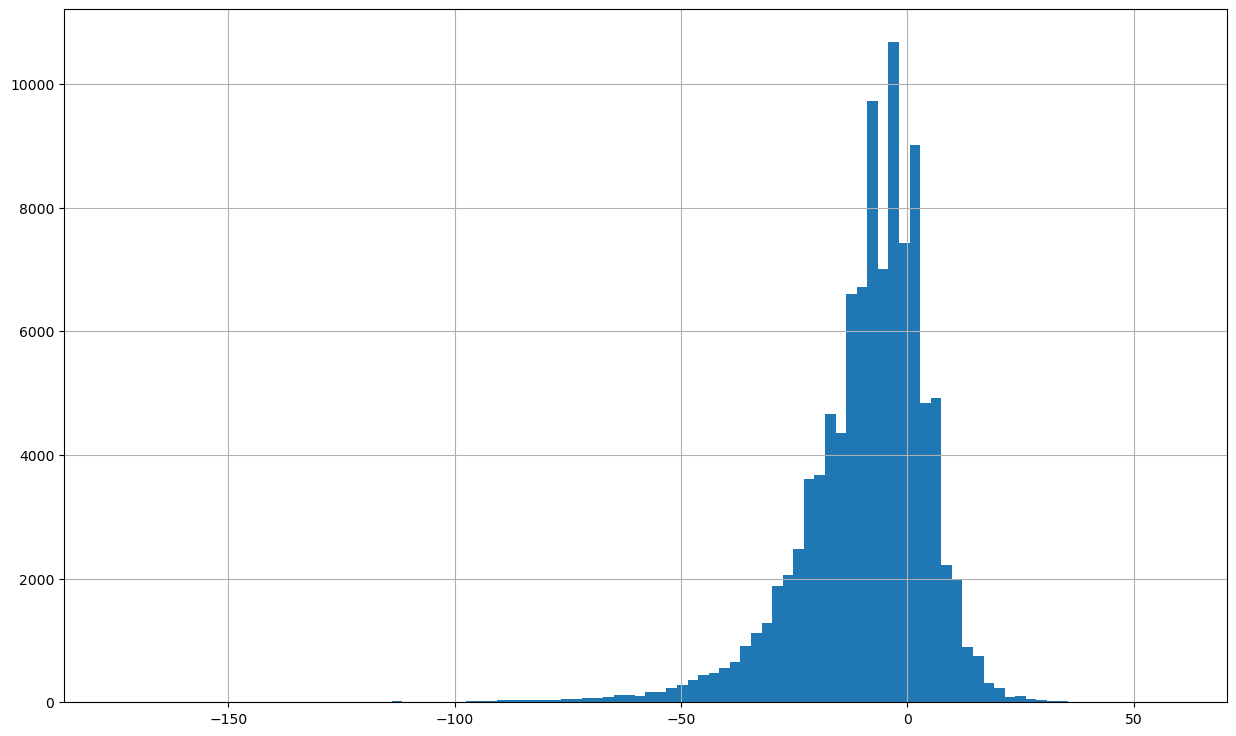

In [39]:
df["y_predict"].hist(bins=100)

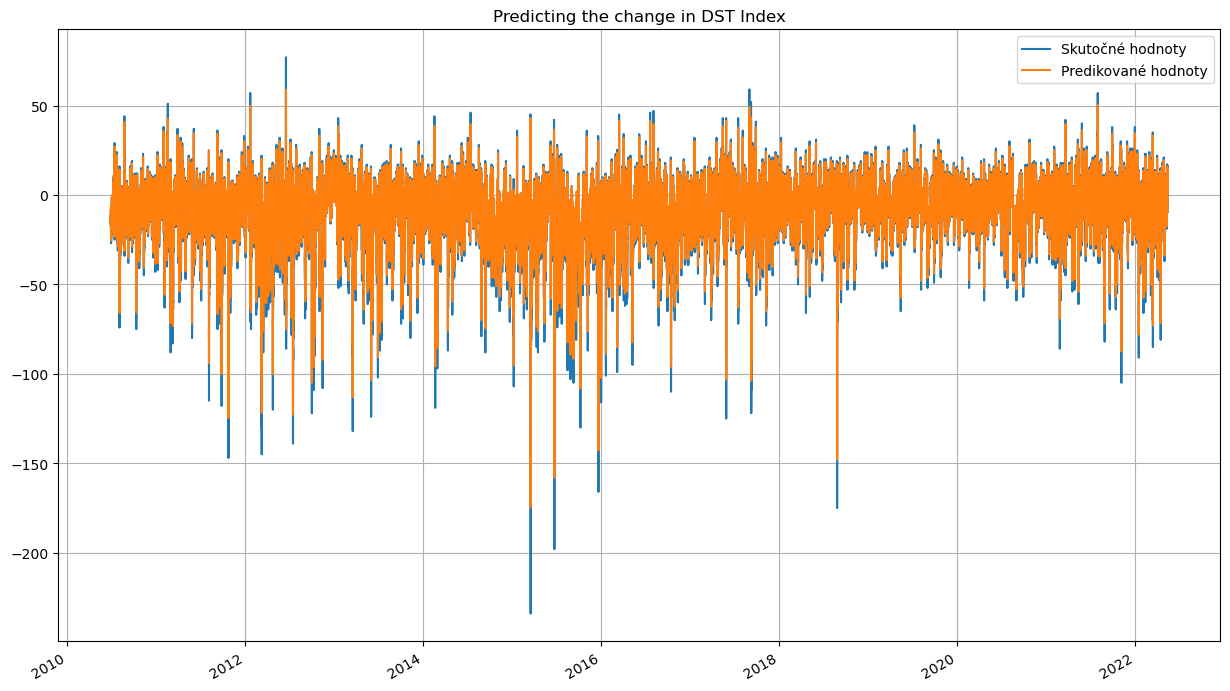

In [40]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [41]:
df.to_csv('predikcie_6h_dozadu_6h_dopredu.csv')